# Disease detection from Chest X-Ray

## Project Goal:

Build a deep learning model that can classify chest X-ray images as either Normal or Pneumonia, helping demonstrate how AI can support medical diagnosis.

📦 Dataset:

Chest X-Ray Images (Pneumonia) - Kaggle: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia





- 5,863 total images across training, test, and validation folders



- Two classes: NORMAL, PNEUMONIA

In [11]:
import tensorflow as tf
import os

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Load dataset

In [12]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
data_dir = "/content/drive/MyDrive/chest_xray"

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_gen = train_datagen.flow_from_directory(
    f"{data_dir}/train", target_size=(150,150), class_mode='binary', batch_size=32
)

Found 5244 images belonging to 2 classes.


In [16]:
test_gen = train_datagen.flow_from_directory(
    directory=f"{data_dir}/test",
    target_size=(150, 150),
    class_mode='binary',
    batch_size=32,
)

Found 624 images belonging to 2 classes.


## Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

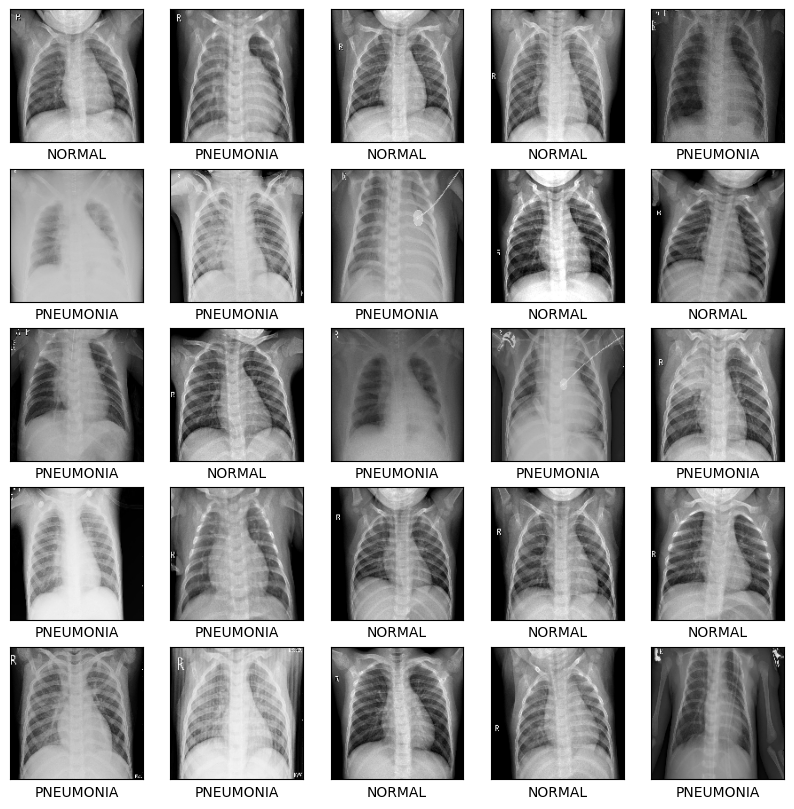

In [17]:

class_names = ['NORMAL', 'PNEUMONIA']

# Get 25 sample images from the training generator
images, labels = next(train_gen)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i])
    label = int(labels[i])
    plt.xlabel(class_names[label])
plt.show()


In [18]:
from collections import Counter
def count_classes(folder):
    normal = len(os.listdir(f"{folder}/NORMAL"))
    pneumonia = len(os.listdir(f"{folder}/PNEUMONIA"))
    return {'NORMAL': normal, 'PNEUMONIA': pneumonia}

print("Train:", count_classes(f"{data_dir}/train"))
print("Test:", count_classes(f"{data_dir}/test"))

Train: {'NORMAL': 1350, 'PNEUMONIA': 3896}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


There is a significant class imbalance, let's compute classs weights

In [19]:
from sklearn.utils import class_weight
import numpy as np
# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

In [20]:
class_weights_dict = dict(enumerate(class_weights))
print("Class weights dictionary:", class_weights_dict)

Class weights dictionary: {0: np.float64(1.943661971830986), 1: np.float64(0.6731707317073171)}


## Create the convolutional base

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Let's display the architecture of your model so far:

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

##  Add Dense layers on top

In [23]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid')) # Change output layer for binary classification

Here's the complete architecture of your model:

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,081 (1.12 MB)

 Trainable params: 294,081 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

## Compile & Train

In [25]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

history = model.fit(train_gen, validation_data=test_gen, epochs=10, class_weight=class_weights_dict)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 78s 449ms/step - accuracy: 0.7338 - loss: 0.4578 - val_accuracy: 0.7628 - val_loss: 0.7359
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9516 - loss: 0.1257 - val_accuracy: 0.8317 - val_loss: 0.4513
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 400ms/step - accuracy: 0.9529 - loss: 0.1161 - val_accuracy: 0.7532 - val_loss: 1.0671
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.9690 - loss: 0.0795 - val_accuracy: 0.7981 - val_loss: 0.7537
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 399ms/step - accuracy: 0.9568 - loss: 0.1015 - val_accuracy: 0.7788 - val_loss: 0.9936
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 395ms/step - accuracy: 0.9776 - loss: 0.0589 - val_accuracy: 0.7837 - val_loss: 0.8809
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 399ms/step - accuracy: 0.9806 - loss: 0.0559 - val_accuracy: 0.7821 - val_loss: 0.8601
Epoch 8/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 65s 397ms/step - accuracy: 0.9868 - loss: 0

while training accuracy increases and loss decreases, val_accuracy kept the same interval, and val_loss increased then decreased at the last epoch; no clear overfitting

## Evaluation

Metrics + Confusion Matrix

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step
              precision    recall  f1-score   support

      NORMAL       0.38      1.00      0.55       234
   PNEUMONIA       0.00      0.00      0.00       390

    accuracy                           0.38       624
   macro avg       0.19      0.50      0.27       624
weighted avg       0.14      0.38      0.20       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


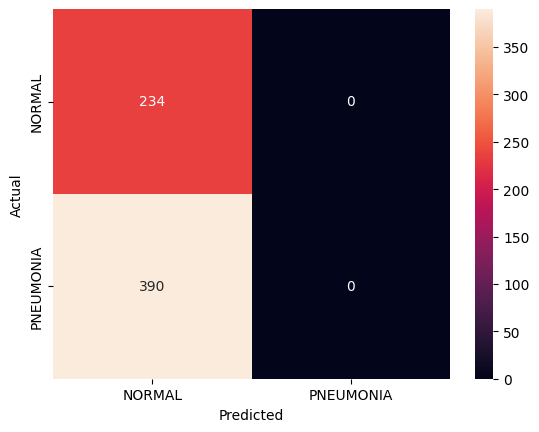

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The current model achieves moderate performance in detecting pneumonia, with higher recall (76%) but limited precision (62%), while its ability to correctly classify normal cases is poor (24% recall). The overall accuracy of 56% indicates the model requires significant improvement before clinical application. Future work should focus on addressing class imbalance, improving model architecture, and refining decision thresholds to enhance both sensitivity and specificity.

Training Curves

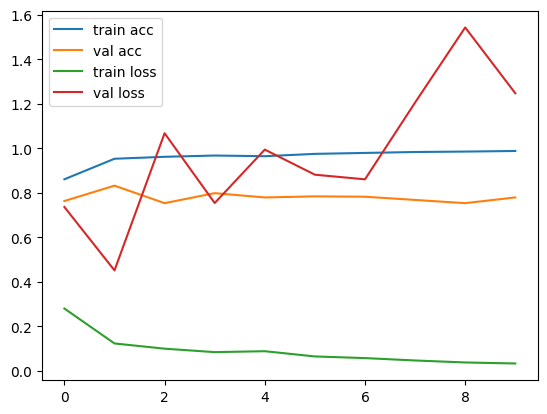

In [29]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

## Interpretation & Conclusion

The model shows moderate success in detecting pneumonia cases, with a recall of 75%, meaning it correctly identifies most pneumonia patients. However, its performance in recognizing normal (healthy) cases is poor, with only 22% recall, indicating many healthy cases are misclassified. The overall accuracy of 55% suggests the model’s predictions are only slightly better than random guessing.

These results indicate that the model needs further improvement, especially to better distinguish normal cases and reduce false positives. Typically, this would involve retraining with more data, adjusting model architecture and data imbalances, or tuning thresholds.

Due to limited internet connectivity causing slow training times, I am pausing further retraining at this stage. Future work will focus on addressing these issues to enhance the model’s reliability and clinical usefulness.